# Preparing Data for Modelling

In [12]:
"""This notebook fits a GLM and a Linear Regression to evaluate predictors' influence on lateness"""
import os
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import yaml
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score


features_list = [
    "route",
    "route_variant",
    "direction",
    "transit_stop",           
    "transit_stop_sequence",  
    "suburb",
    "depot",
    "bus_configuration",
    "seated_capacity",        
    "standing_capacity",      
    "total_capacity",         
    "capacity_bucket",
    "is_weekend",             
    "timetable_hr_sin",
    "timetable_hr_cos",
    "timetable_min_sin",
    "timetable_min_cos",
    "day_of_week_sin",
    "day_of_week_cos",
    "lateness_minutes"
]


config_path = Path.cwd().parent / "config.yaml"
with open("config.yaml",  encoding="utf-8") as f:
    config = yaml.safe_load(f)
df_path = config["processed_path"] + "sample_10k.csv"


df = pd.read_csv(df_path, usecols=features_list])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10113 entries, 0 to 10112
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   route                  10113 non-null  object 
 1   route_variant          10113 non-null  object 
 2   direction              10113 non-null  object 
 3   transit_stop           10113 non-null  int64  
 4   transit_stop_sequence  10113 non-null  int64  
 5   suburb                 10113 non-null  object 
 6   depot                  10113 non-null  object 
 7   bus_configuration      10113 non-null  object 
 8   seated_capacity        10113 non-null  int64  
 9   standing_capacity      10113 non-null  int64  
 10  total_capacity         10113 non-null  int64  
 11  capacity_bucket        10113 non-null  object 
 12  is_weekend             10113 non-null  int64  
 13  timetable_hr_sin       10113 non-null  float64
 14  timetable_hr_cos       10113 non-null  float64
 15  ti

## Create dummy variables 

In [2]:
# Preparing encoding categories
categorical_features = ["route", "route_variant", "bus_configuration",
                        "direction", "transit_stop", "suburb",
                        "depot", "transit_stop_sequence", "capacity_bucket"]
encoded_df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

## Train-test Split

In [3]:
X = encoded_df.drop("lateness_minutes", axis = 1)
y = encoded_df["lateness_minutes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model Training and Evaluation

In [4]:
linear_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

glm_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("glm",  TweedieRegressor(power=0, max_iter=1000))
])

# Define parameter grids for each model separately
linear_param_grid = {
    "lr__fit_intercept": [True, False],
}

glm_param_grid = {
    "glm__alpha": [0.001, 0.01, 0.1, 1.0], 
    "glm__fit_intercept": [True, False]
}

In [5]:
print("Running GridSearchCV for Linear Regression...")
linear_grid_search = GridSearchCV(
    linear_pipeline,
    param_grid=linear_param_grid,
    cv=3,
    scoring="r2",
    n_jobs=None,
    refit=True,
    return_train_score=True,
    verbose=1
)

linear_grid_search.fit(X_train, y_train)

Running GridSearchCV for Linear Regression...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,estimator,Pipeline(step...egression())])
,param_grid,"{'lr__fit_intercept': [True, False]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


In [6]:
print("Running GridSearchCV for GLM...")
glm_grid_search = GridSearchCV(
    glm_pipeline,
    param_grid=glm_param_grid,
    cv=3,
    scoring="r2",
    n_jobs=None,
    refit=True,
    return_train_score=True,
    verbose=1
)

glm_grid_search.fit(X_train, y_train)

Running GridSearchCV for GLM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


,estimator,"Pipeline(step...0, power=0))])"
,param_grid,"{'glm__alpha': [0.001, 0.01, ...], 'glm__fit_intercept': [True, False]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


In [7]:
best_linear_model = linear_grid_search.best_estimator_
best_glm_model = glm_grid_search.best_estimator_


# Make predictions
train_pred_glm = best_glm_model.predict(X_train)
test_pred_glm = best_glm_model.predict(X_test)
train_pred_linear = best_linear_model.predict(X_train)
test_pred_linear = best_linear_model.predict(X_test)

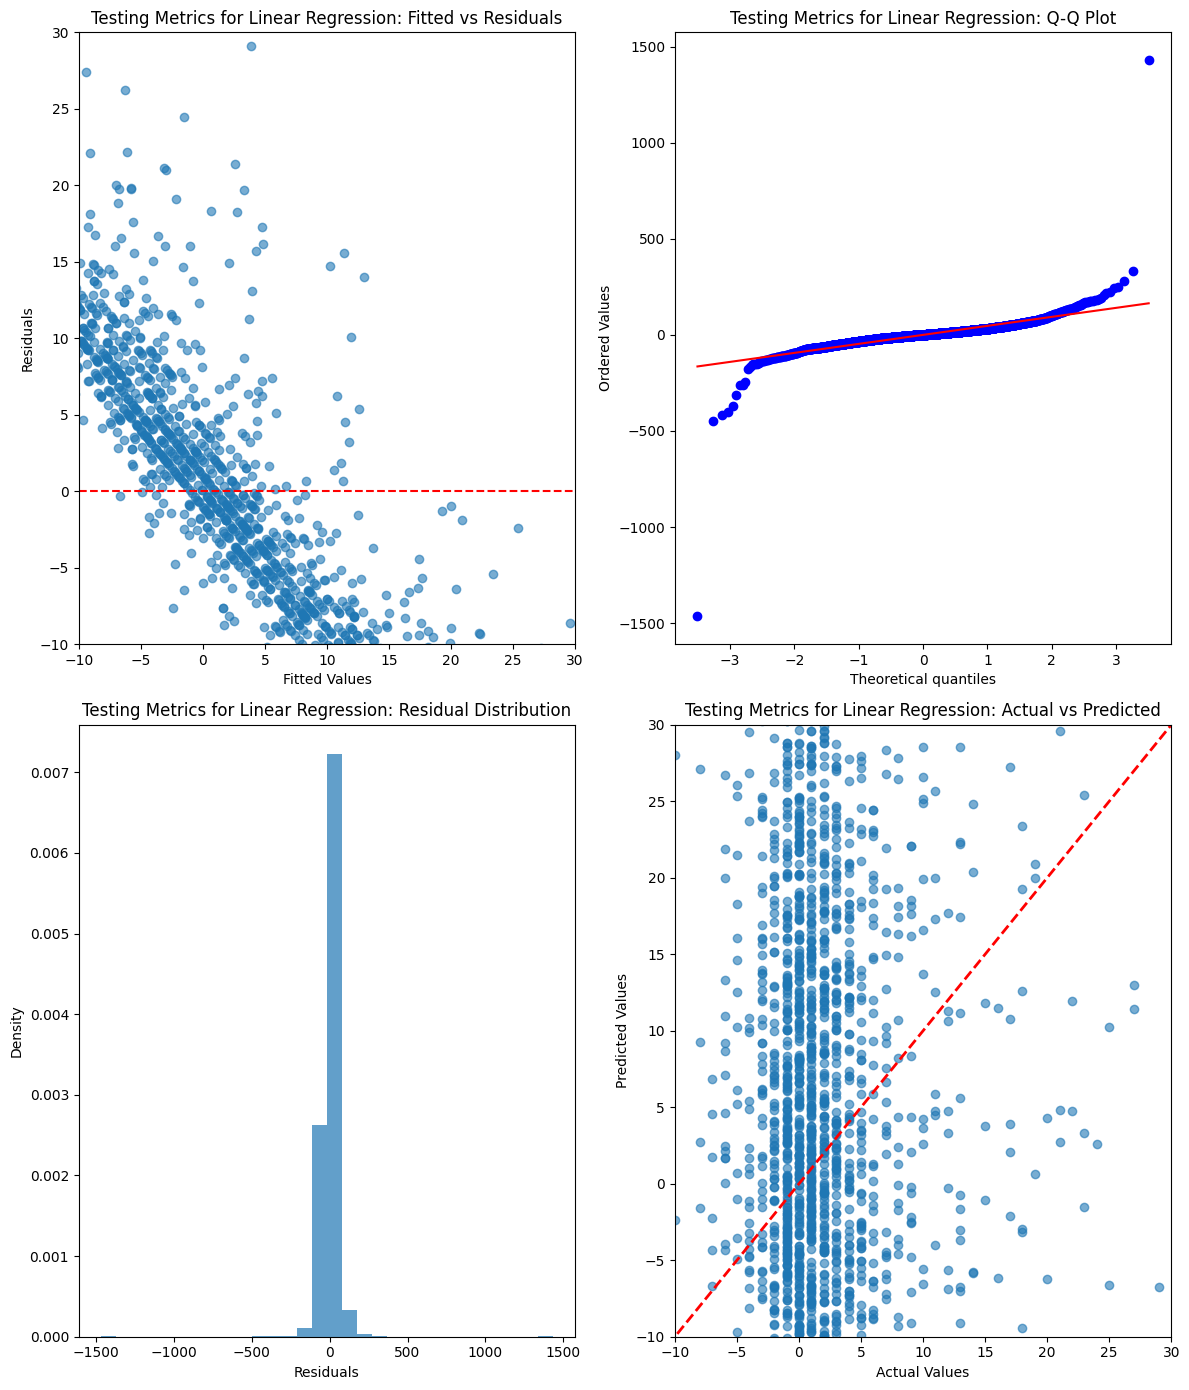

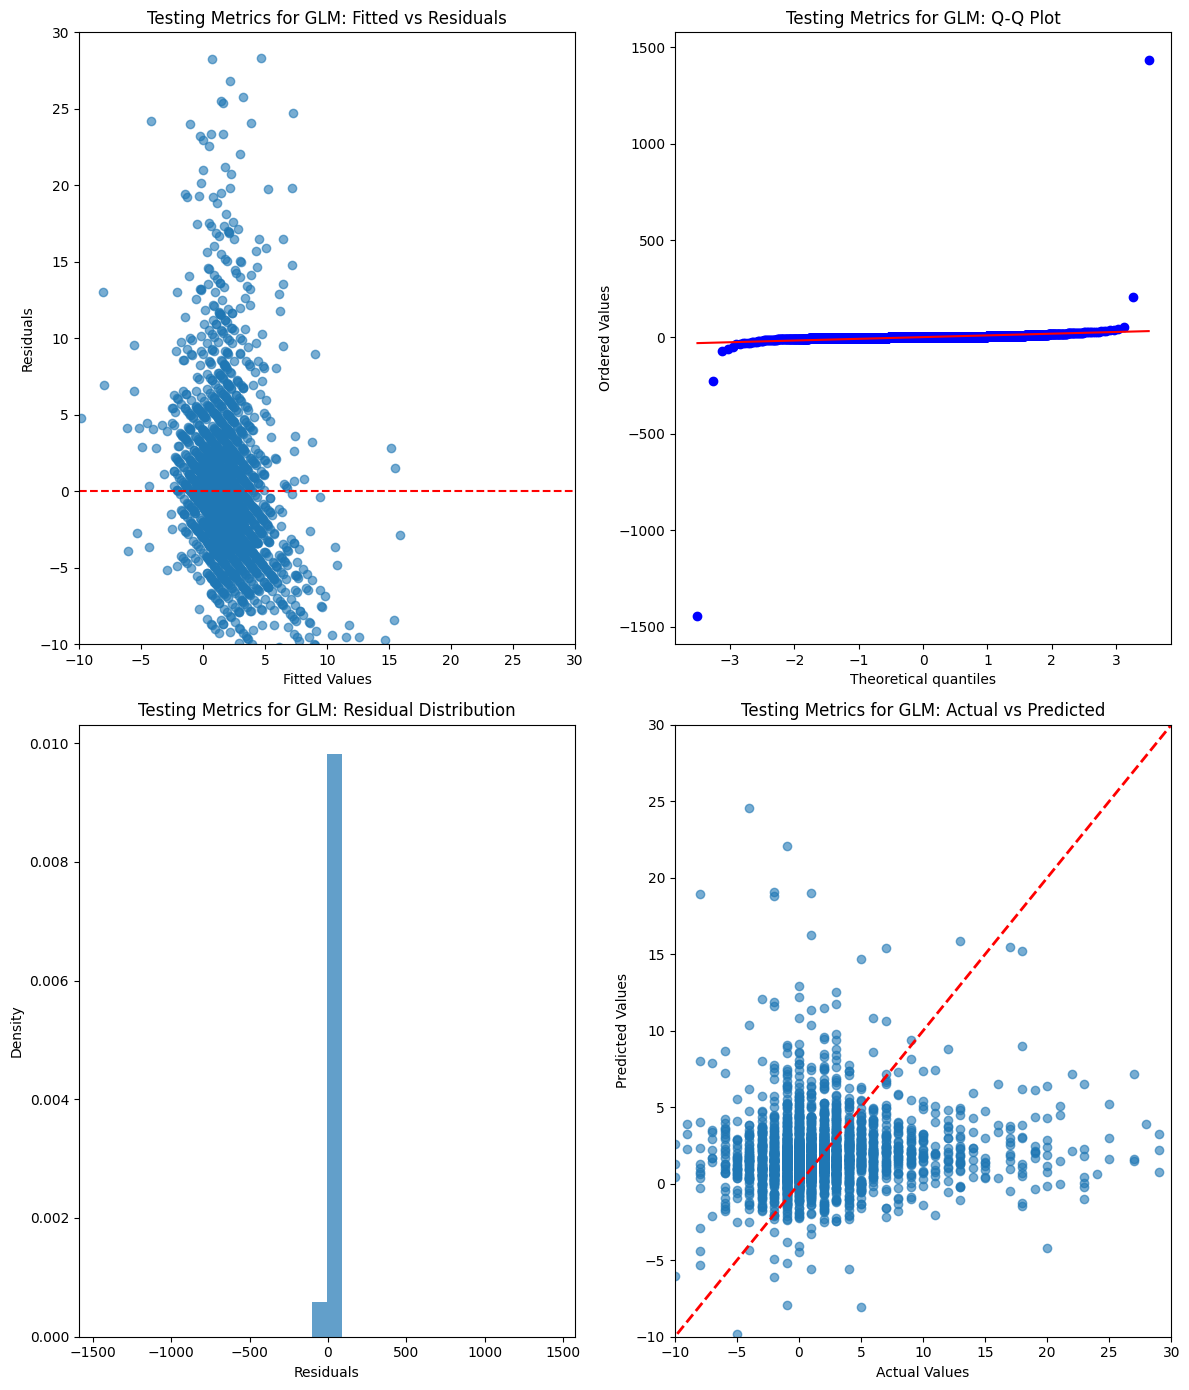

In [22]:
# Diagnostic plots functions
def plot_regression_diagnostics(model, y, y_pred, title_prefix="", model_name="lr"):
    """ Create diagnostic plots for linear regression"""
    fig, axes=plt.subplots(2, 2, figsize=(12, 14))
    
    # 1. Fitted vs Residuals
    residuals = y - y_pred
    axes[0, 0].scatter(y_pred, residuals, alpha=0.6)
    axes[0, 0].axhline(y=0, color="r", linestyle="--")
    axes[0, 0].set_xlabel("Fitted Values")
    axes[0, 0].set_ylabel("Residuals")
    axes[0, 0].set_title(f"{title_prefix}Fitted vs Residuals")
    axes[0, 0].set_ylim([-10, 30])
    axes[0, 0].set_xlim([-10, 30])
    
    # 2. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title(f"{title_prefix}Q-Q Plot")
    
    # 3. Histogram of Residuals
    axes[1, 0].hist(residuals, bins=30, alpha=0.7, density=True)
    axes[1, 0].set_xlabel("Residuals")
    axes[1, 0].set_ylabel("Density")
    axes[1, 0].set_title(f"{title_prefix}Residual Distribution")
    
    # 4. Actual vs Predicted
    axes[1, 1].scatter(y, y_pred, alpha=0.6)
    axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
    axes[1, 1].set_xlabel("Actual Values")
    axes[1, 1].set_ylabel("Predicted Values")
    axes[1, 1].set_xlim([-10, 30])
    axes[1, 1].set_ylim([-10, 30])
    axes[1, 1].set_title(f"{title_prefix}Actual vs Predicted")
    
    plt.tight_layout()
    plt.savefig(f"{model_name}_results.png")


# Print coefficients and statistics
def print_model_summary(model, X_train, y_train, y_test, y_train_pred, y_test_pred, model_name="lr"):
    base_name = "metrics"
    extension = ".txt"
    file_name = base_name +'_' + model_name + extension
    counter = 1
    while os.path.exists(file_name):
        file_name = f"{base_name}_-{counter}{extension}"
        counter += 1
    with open(file_name, mode="x", encoding="utf-8") as f:
        print("=== Regression Results ===", file=f)
        print(f"R² (Train): {r2_score(y_train, y_train_pred):.4f}", file=f)
        print(f"R² (Test): {r2_score(y_test, y_test_pred):.4f}", file=f)
        print(f"RMSE (Train): {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}", file=f)
        print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}", file=f)
        
        print("\n=== Feature Coefficients ===", file=f)
        coef_df=pd.DataFrame({
            "Feature": X_train.columns,
            "Coefficient": model.named_steps[f"{model_name}"].coef_,
            "Abs_Coefficient": np.abs(model.named_steps[f"{model_name}"].coef_)
        }).sort_values("Abs_Coefficient", ascending=False)
        
        print(coef_df.to_string(index=False), file=f)
        print(f"\nIntercept: {model.named_steps[f'{model_name}'].intercept_:.4f}", file=f)


if __name__ == "__main__":
    plot_regression_diagnostics(best_linear_model, y_test, test_pred_linear, "Testing Metrics for Linear Regression: ")
    plot_regression_diagnostics(best_glm_model, y_test, test_pred_glm, "Testing Metrics for GLM: ", "glm")
    print_model_summary(best_glm_model, X_train, y_train, y_test, train_pred_glm, test_pred_glm, model_name= "glm" )
    print_model_summary(best_linear_model, X_train, y_train, y_test, train_pred_linear, test_pred_linear)